# <font color=red>HW01-q3 Vision Course, Homography</font>
This is the notebook for **q3.py** that is the implementation of **Homography**. <br>
The code is written by **Asal Mehradfar** with student number **96105434**.

## <font color=orange>Description</font>
My approach is explained below:

*    I use *SIFT_create()* in open-cv for all the steps, so upgrading open-cv is needed in *Google Colab*. <br><br>
*   In this question, I work with colorful images. So at the first step I convert the image to the RGB one. <br><br>
*   For getting the interest points of the images, we can use *detect* or *detectAndCompute*. I used the 2nd one because we need the descriptors for the next steps. Pay attention that detect DOESN'T give us descriptors.<br><br>
*   Then I draw the interest points on the two images seperately by *drawKeyPoints* instruction. Pay attention that keypoints consist of different parts, but we don't need to seperate them for this step. <br><br>
*   Then I use *BFMatcher* for finding the matches. I used to make the *crossCheck* boolean *True* and **Norm_L1**, but it took a long time to be executed. I changed my way to **knnMatch** with **False crossCheck** and **$k=2$**. This way was a lot faster. <br><br>
*   Now we should check the ratio between the distance of two outputs of each match, exactly the same as what we did in q1. I have chosen the ratio as 0.7 here. With this approach we get good matches.<br><br>
*   I prefered to sort the good matches with regard to their **distance**. You can easily omit this line.<br><br>
*   The same as the first plot, I used *drawKeyPoints* for drawing match points. I used the .queryIdx and .trainIdx feature of matches. There are a few match points in this step, so finding them needs a zoom on the image!!!<br><br>
*   I used *drawMatchesKnn* for drawing the match lines between two images. For the part that we want to plot 20 of the line matches, I used to plot the first 20 matches of the sorted ones.<br><br>
*   At last I have given the *findHomography* instruction the points of the source and destination to apply **RANSAC Algorithm**. This Algorithm will remove all the matches that are not correct. I have shown wrong lines of primary mathces with blue and true matches with red. We can find inliers using the status, one of the outputs of findHomography.<br><br>
*   To apply the homography on the 2nd image, I use *warpPerspective* and the inverse matrix of H, the output of *findHomography*. But depending on the default size of the output image and the final magnitude of the output array, we may see the first image cropped. In order to solve the problem, I have mentioned the output size myself by testing. I also added a matrix as an **OFFSET** to **H**. By multiplying this matrix, we will not have negative points in the output. Pay attention that I found the offset parameters and the size just by test.
$$offset =\begin{bmatrix} 1 & 0 & X \\ 0 & 1 & Y \\ 0 & 0 & 1 \end{bmatrix} = \begin{bmatrix} 1 & 0 & 2700 \\ 0 & 1 & 1100 \\ 0 & 0 & 1 \end{bmatrix}$$
*   $$H =\begin{bmatrix} 0.263 & 0.025 & 613.701 \\ -0.015 & 0.503 & 468.830 \\ 0 & 0 & 1 \end{bmatrix}$$
$$H^{-1} =\begin{bmatrix} 3.611 & 0.292 & -2352.980 \\ 0.034 & 2.196 & -1050.546 \\ 0 & 0 & 1.054 \end{bmatrix}$$
$$offset \times H^{-1} =\begin{bmatrix} 3.819 & -0.289 & 491.832 \\ 0.118 & 1.960 & 108.45 \\ 0 & 0 & 1.054 \end{bmatrix}$$<br>
The zeros above are not exactly zero. They are around zero.  
*   At last **No mismatch found**!!!






### <font color=yellow>Upgrading Open-CV in Google Colab</font>

In [1]:
!pip3 install --upgrade opencv-python

     |████████████████████████████████| 49.9 MB 17 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


### <font color=yellow>Imports</font>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

### <font color=yellow>Parameters</font>

*   MAX_ITERATIONS = 10000

In [3]:
R = 0.7 # ratio for knn match
MAX_ITERATIONS = 10000
X_OFFSET = 2700
Y_OFFSET = 1100
X_SIZE = 9500
Y_SIZE = 3500

### <font color=yellow>Functions</font>

In [4]:
def plot_img(img, path= None):
    """
    Plot a colorful image and save it if needed
    
    Inputs:
    --> img: the desired image
    --> path: the default value is None, if it is given the image will be saved in the path
    Outputs:
    ==> Nothing, the image will be plotted
    """
    fig = plt.figure(figsize=(16, 8))
    plt.imshow(img)
    plt.axis('off')
    if path != None:
        fig.savefig(path, bbox_inches='tight')
    plt.show()

def plot_two_imgs(img1, img2, path = None):
    """
    Plot two colorful images with subplot and save it if needed
    
    Inputs:
    --> img1: the first desired image
    --> img2: the second desired image
    --> path: the default value is None, if it is given the image will be saved in the path
    Outputs:
    ==> Nothing, the image will be plotted
    """
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(img1)
    ax[0].axis('off')
    ax[1].imshow(img2)
    ax[1].axis('off')
    if path != None:
        fig.savefig(path, bbox_inches='tight')
    plt.show()

def get_img(path):
    """
    Read the image file from the path and change it from BGR to RGB
    pay attention that in open-cv colorful images are BGR **NOT** RGB
    
    Inputs:
    --> path: path for the image
    Outputs:
    ==> img: the RGB image
    """
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

def automatic_sift(img1, img2, flag=False):
    """
    Finding match points between two images by RANSAC Algorithm

    Inputs:
    --> img1: the first desired image
    --> img: the second desired image
    --> flag: the default value is False, if it is True the outputs will be saved.
    Outputs:
    ==> Nothing, just plot outputs
    """

    kp1, kp2, good_matches = sift(img1, img2, R, True)

    # draw all key points
    img1_kp = cv2.drawKeypoints(img1, kp1, None, color=[0, 255, 0])
    img2_kp = cv2.drawKeypoints(img2, kp2, None, color=[0, 255, 0])

    good_matches = sorted(good_matches, key=lambda x: x[0].distance)  # we can omit this line

    # draw good match points
    kp1_match = [kp1[m[0].queryIdx] for m in good_matches]
    img1_match = cv2.drawKeypoints(img1_kp, kp1_match, None, color=[0, 0, 255])
    kp2_match = [kp2[m[0].trainIdx] for m in good_matches]
    img2_match = cv2.drawKeypoints(img2_kp, kp2_match, None, color=[0, 0, 255])

    # draw good match lines
    match_lines = cv2.drawMatchesKnn(img1_match, kp1, img2_match, kp2, good_matches, None, flags=2,
                                     singlePointColor=(0, 0, 255), matchColor=(0, 0, 255))
    match_lines_final = cv2.drawMatchesKnn(img1_match, kp1, img2_match, kp2, good_matches[:20], None, flags=2,
                                           singlePointColor=(0, 0, 255), matchColor=(0, 0, 255))

    # apply RANSAC and find inliers
    src_pts = np.float32([kp.pt for kp in kp1_match]).reshape(-1, 1, 2)
    des_pts = np.float32([kp.pt for kp in kp2_match]).reshape(-1, 1, 2)
    H, status = cv2.findHomography(src_pts, des_pts, cv2.RANSAC, maxIters=MAX_ITERATIONS)
    inlier = []
    for i in range(len(good_matches)):
        if status[i] == 1:
            inlier.append(good_matches[i])

    match_lines_no_points = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2,
                                               singlePointColor=(0, 0, 255), matchColor=(0, 0, 255))
    inlier_lines = cv2.drawMatchesKnn(img1, kp1, img2, kp2, inlier, match_lines_no_points.copy(),
                                      flags=(cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG + 2),
                                      singlePointColor=(255, 0, 0), matchColor=(255, 0, 0))
    # inlier_lines = cv2.drawMatchesKnn(img1, kp1, img2, kp2, inlier, None, flags = 2,
    #                                   singlePointColor = (255, 0, 0), matchColor= (255, 0, 0))   # just inliers

    # homography
    img_homography = perspective(img2, np.linalg.inv(H))

    if flag:
        plot_two_imgs(img1_kp, img2_kp, 'res13_corners.jpg')
        plot_two_imgs(img1_match, img2_match, 'res14_correspondences.jpg')
        plot_img(match_lines, 'res15_matches.jpg')
        plot_img(match_lines_final, 'res16.jpg')
        plot_img(inlier_lines, 'res17.jpg')
        plot_img(img_homography, 'res19.jpg')
    else:
        plot_two_imgs(img1_kp, img2_kp)
        plot_two_imgs(img1_match, img2_match)
        plot_img(match_lines)
        plot_img(match_lines_final)
        plot_img(inlier_lines)
        plot_img(img_homography)

def sift(img1, img2, R, flag=False):
    """
    Finding match points between two images by RANSAC Algorithm

    Inputs:
    --> img1: the first desired image
    --> img2: the second desired image
    --> R: the accepted ratio for distance between matches
    -->
    Outputs:
    ==> kp1: key points of the first image
    ==> kp2: key points of the second image
    ==> good_matches: good matches of two images
    """

    sift_cr = cv2.SIFT_create()

    # find all key points
    kp1, des1 = sift_cr.detectAndCompute(img1, None)
    kp2, des2 = sift_cr.detectAndCompute(img2, None)

    # find all matches
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=False)
    matches = bf.knnMatch(des1, des2, k=2)

    # find good matches
    good_matches = []
    for m, n in matches:
        if m.distance < R * n.distance:
            if flag:
                good_matches.append([m])
            else:
                good_matches.append(m)

    return kp1, kp2, good_matches


def perspective(img, H):
    """
    computing the homography of the image with matrix H

    Inputs:
    --> img: the desired image
    --> H: the homography matrix
    Outputs:
    ==> img_homography: the output image
    """
    x_min, y_min, x_max, y_max = corners_homography(img, H)
    [x_offset, y_offset] = [-x_min, -y_min]
    [x_size, y_size] = [x_max - x_min, y_max - y_min]
    offset = np.array([[1, 0, x_offset], [0, 1, y_offset], [0, 0, 1]])
    img_homography = cv2.warpPerspective(img, np.dot(offset, H), (x_size, y_size))
    return img_homography


def corners_homography(img, H):
    """
    computing the min and max of the corners of an image
    after applying the homography matrix without offset
    we use these points to find offset and size of the homography

    Inputs:
    --> img: the desired image
    --> H: the homography matrix
    Outputs:
    ==> x_min: minimum x after homography
    ==> y_min: minimum y after homography
    ==> x_max: maximum x after homography
    ==> y_max: maximum y after homography
    """
    height, width, _ = img.shape
    corners = [np.array([[0, 0, 1]]).transpose(),
               np.array([[width - 1, 0, 1]]).transpose(),
               np.array([[0, height - 1, 1]]).transpose(),
               np.array([[width - 1, height - 1, 1]]).transpose()]
    [x_min, y_min, x_max, y_max] = [-1 for _ in range(4)]
    for c in corners:
        m = np.matmul(H, c)
        if x_min == -1:
            [x_min, y_min, x_max, y_max] = [int(m[0] / m[2]),
                                            int(m[1] / m[2]),
                                            int(m[0] / m[2]),
                                            int(m[1] / m[2])]
        else:
            [x_min, y_min, x_max, y_max] = [min(x_min, int(m[0] / m[2])),
                                            min(y_min, int(m[1] / m[2])),
                                            max(x_max, int(m[0] / m[2])),
                                            max(y_max, int(m[1] / m[2]))]
    return x_min, y_min, x_max, y_max

### <font color=yellow>Main Part, Test on im03.jpg and im04.jpg</font>

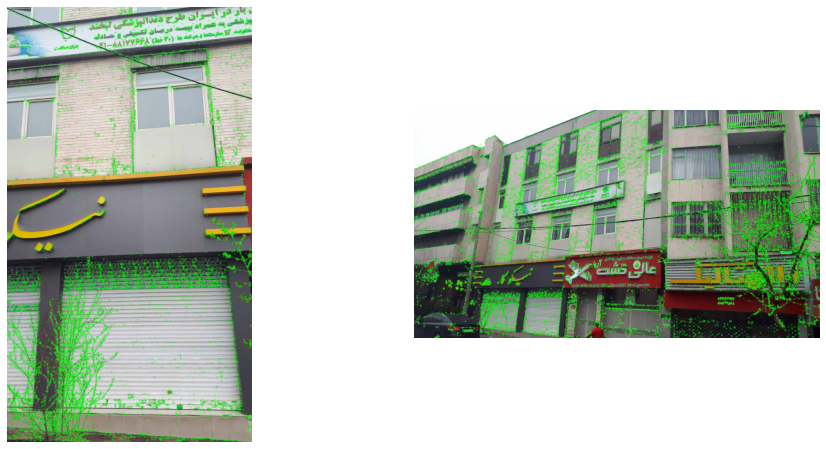

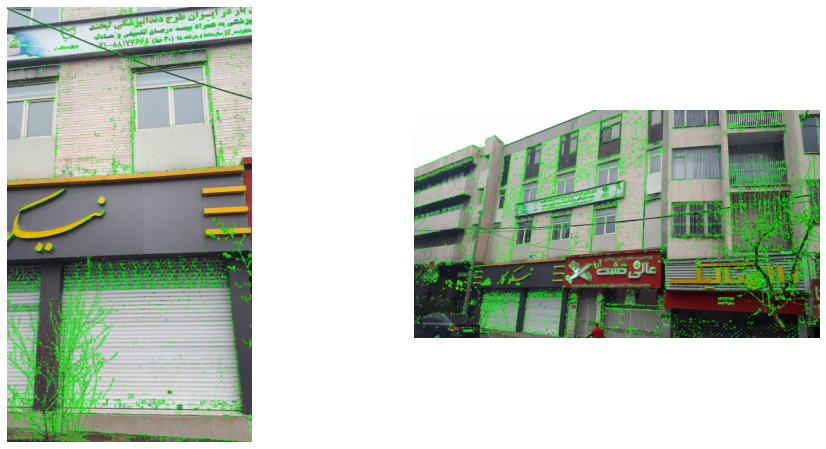

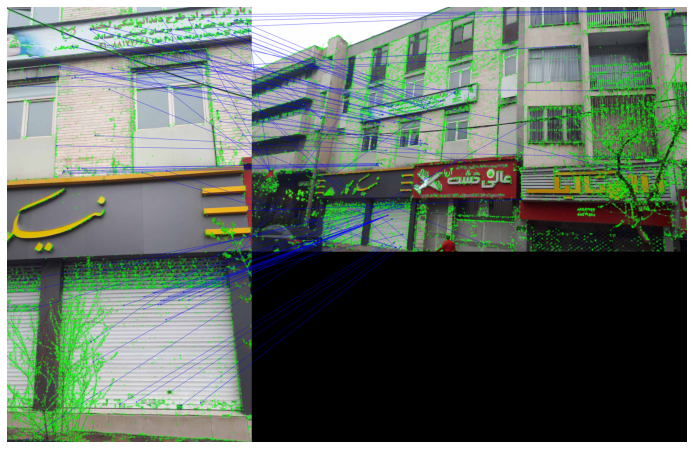

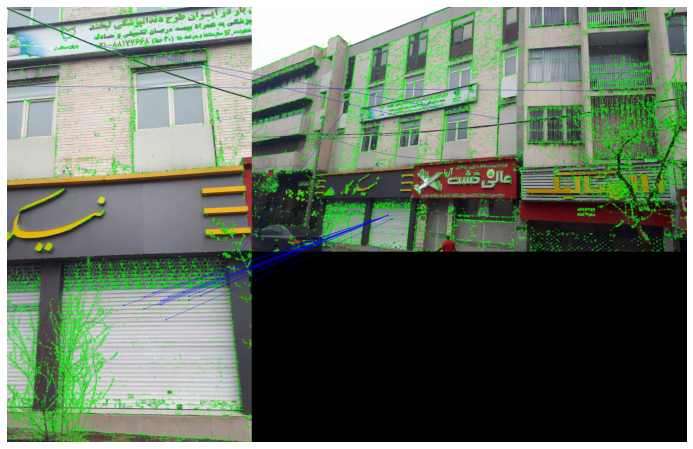

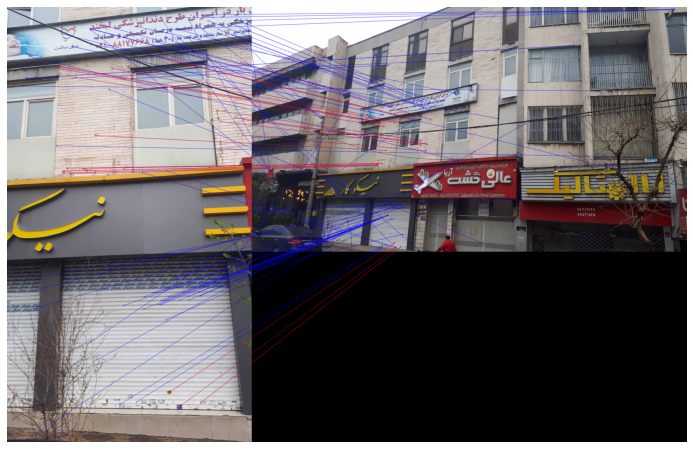

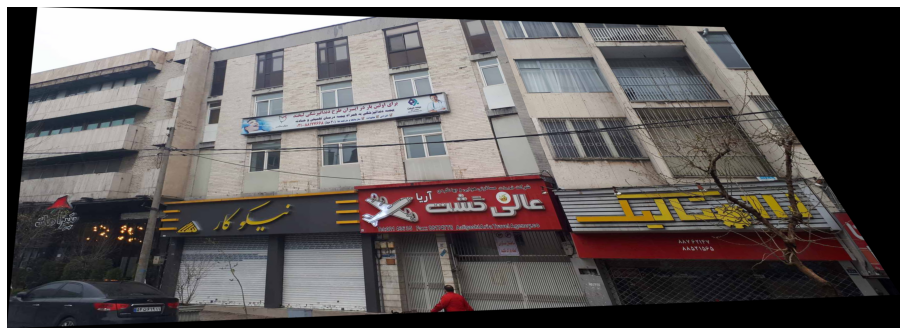

In [5]:
img1 = get_img('im03.jpg')
img2 = get_img('im04.jpg')
automatic_sift(img1, img2, True)